# word2vecの高速化

- 前章のCBOWモデルは, 語彙数が増えるに従い計算量が増加するという欠点がある
  - ex)語彙数100万, 中間層のニューロン数100とすると, 入力側の重み$W_{in}$は$10^6 \times 100 \times N$($N$はコンテキスト数), 出力側の重み$W_{out}$は$100 \times 10^6$となる

- このモデルのボトルネックとなる点は以下の2つである
  - 入力層のone-hot表現と重み行列$W_{in}$の積計算
  - 中間層と重み行列$W_{out}$の積, 及びSoftmaxレイヤの計算

- 上記2点の解決策
  - 1つ目の解決策としてEmbeddingレイヤを導入
  - 2つ目の解決策として損失関数Negatice Samplingを導入

### 前準備(各種ライブラリのimport)

In [48]:
import numpy as np
import collections
import pickle

from common import config
from common.np import *
from common.functions import cross_entropy_error
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu, most_similar
from dataset import ptb

# GPUを使用する場合以下の行のコメントアウトを消去(Cupyが必要)
# config.GPU = True

## word2vecの改良① Embeddingレイヤ

- 重みパラメータから単語IDに該当するベクトルを抜き取るレイヤ
  - これによってone-hot表現への変換とMatMulレイヤでの行列乗算は不要となる

- 以下のようにnumpyでindexを指定することでその部分だけを抜き取れる

In [49]:
tmp = np.arange(21).reshape(7, 3)
print(tmp)
print('-'*50)
print(tmp[2])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
--------------------------------------------------
[6 7 8]


---

In [50]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
    
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

---

## word2vecの改良② Negative Sampling

- ここまでのword2vecでは多値分類を行ってきた
  - ex)コンテキスト"you", "goodbye"を与える→"say"という単語の確率が高くなるような学習を行っていた
- これを二値分類として解決することで計算量削減を図る
  - ex)「コンテキストが"you", "goodbye"の時ターゲットは"say"であるか？」→「Yes/No」で解答
  - こうすることで出力層にはニューロンを一つ用意するだけで事足りる
  
- つまり特定の1単語だけに着目しスコアを算出する
  - このスコア→確率へと変換するためにシグモイド関数($y = \frac{1}{1+\exp{(-x)}}$)を適用する
  - シグモイド関数によって得た確率から損失を求めるため交差エントロピー誤差($L = -(t\log y+(1-t)\log(1-y)$)を用いる
  - 上記工程を1つにまとめたもの: Sigmoid with Lossレイヤ

In [51]:
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

---

### Embedding Dotレイヤ

- 中間層のニューロンhと出力側の重み$W_{out}$のターゲットとなる単語に対応する単語ベクトルとの内積を計算
  - これをSigmoid with Lossレイヤに入れることで損失計算を行う
- この計算を一纏めにする為にEmbeddingレイヤと内積の2つの処理を合わせたレイヤ(Embedding Dotレイヤ)を作成する

In [52]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

---

### Negative Sampling

- 現状では正例の単語についての学習しか行っていない
  - 本来行いたいことは, 正例についてはSigmoidレイヤの出力を1に, 負例についてはSigmoidレイヤの出力を0に, それぞれ近づけたい
    - かといって全ての負例を対象に二値分類学習を行うと語彙数が増加すると対応が困難になるので, 負例は少数サンプリングする
- 負例のサンプリングはコーパスの統計データに基づき行う
  - コーパス内での出現率の低い単語は現実においてもあまり出現しない為, 頻出単語をより抽出されやすいようにする

- コーパス内の確率分布$p$を求め, 0.75累乗することで確率の低い単語に対し少しだけ確率を上げることができる
  - 0.75に理論的意味は無いため, 他の数値でも良い
  - 変換後も確率の総和が1になるよう, 分母は変換後の確率分布の総和が必要となる
  - ここで$P(w_i)$はi番目の単語の確率を表している

$$P'(w_i) = \dfrac{P(w_i)^{0.75}}{\sum_j^n P(w_j)^{0.75}}$$

In [53]:
# コーパスから単語の確率分布を作成→power乗→負例をサンプリング
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [54]:
# UnigramSamplerの使用例
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2
s = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
n_s = s.get_negative_sample(target)
print(n_s)

[[3 2]
 [4 1]
 [3 2]]


---

### Negative Samplingの実装

In [63]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1+i].forward(h, negative_target)
            loss += self.loss_layers[1+i].forward(score, negative_label)

        return loss

    # 順伝播と逆順に各レイヤのbackwardを呼べばok
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

---

## 改良版word2vecの学習

In [64]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 重みの初期化
        # 前章と異なり入力側, 出力側の重みの形状は同じ
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
            
        # すべての重みと勾配を配列にまとめる
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

---

### CBOWの学習コード


| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 3[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 5[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 7[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 8[s] | loss 3.93
| epoch 1 |  iter 121 / 9295 | time 10[s] | loss 3.77
| epoch 1 |  iter 141 / 9295 | time 12[s] | loss 3.63
| epoch 1 |  iter 161 / 9295 | time 14[s] | loss 3.50
| epoch 1 |  iter 181 / 9295 | time 16[s] | loss 3.37
| epoch 1 |  iter 201 / 9295 | time 17[s] | loss 3.27
| epoch 1 |  iter 221 / 9295 | time 19[s] | loss 3.17
| epoch 1 |  iter 241 / 9295 | time 21[s] | loss 3.09
| epoch 1 |  iter 261 / 9295 | time 23[s] | loss 3.01
| epoch 1 |  iter 281 / 9295 | time 24[s] | loss 2.99
| epoch 1 |  iter 301 / 9295 | time 26[s] | loss 2.93
| epoch 1 |  iter 321 / 9295 | time 28[s] | loss 2.89
| epoch 1 |  iter 341 / 9295 | time 30[s] | loss 2.85
| epoch 1 |  iter 361 / 9295 | time 31[s

| epoch 1 |  iter 2981 / 9295 | time 258[s] | loss 2.48
| epoch 1 |  iter 3001 / 9295 | time 260[s] | loss 2.43
| epoch 1 |  iter 3021 / 9295 | time 261[s] | loss 2.49
| epoch 1 |  iter 3041 / 9295 | time 263[s] | loss 2.46
| epoch 1 |  iter 3061 / 9295 | time 265[s] | loss 2.44
| epoch 1 |  iter 3081 / 9295 | time 267[s] | loss 2.47
| epoch 1 |  iter 3101 / 9295 | time 268[s] | loss 2.45
| epoch 1 |  iter 3121 / 9295 | time 270[s] | loss 2.44
| epoch 1 |  iter 3141 / 9295 | time 272[s] | loss 2.44
| epoch 1 |  iter 3161 / 9295 | time 274[s] | loss 2.43
| epoch 1 |  iter 3181 / 9295 | time 275[s] | loss 2.46
| epoch 1 |  iter 3201 / 9295 | time 277[s] | loss 2.44
| epoch 1 |  iter 3221 / 9295 | time 279[s] | loss 2.43
| epoch 1 |  iter 3241 / 9295 | time 281[s] | loss 2.40
| epoch 1 |  iter 3261 / 9295 | time 282[s] | loss 2.43
| epoch 1 |  iter 3281 / 9295 | time 284[s] | loss 2.43
| epoch 1 |  iter 3301 / 9295 | time 286[s] | loss 2.43
| epoch 1 |  iter 3321 / 9295 | time 287[s] | lo

| epoch 1 |  iter 5921 / 9295 | time 523[s] | loss 2.30
| epoch 1 |  iter 5941 / 9295 | time 525[s] | loss 2.31
| epoch 1 |  iter 5961 / 9295 | time 527[s] | loss 2.33
| epoch 1 |  iter 5981 / 9295 | time 529[s] | loss 2.28
| epoch 1 |  iter 6001 / 9295 | time 530[s] | loss 2.33
| epoch 1 |  iter 6021 / 9295 | time 532[s] | loss 2.30
| epoch 1 |  iter 6041 / 9295 | time 534[s] | loss 2.34
| epoch 1 |  iter 6061 / 9295 | time 536[s] | loss 2.34
| epoch 1 |  iter 6081 / 9295 | time 537[s] | loss 2.33
| epoch 1 |  iter 6101 / 9295 | time 539[s] | loss 2.31
| epoch 1 |  iter 6121 / 9295 | time 541[s] | loss 2.32
| epoch 1 |  iter 6141 / 9295 | time 543[s] | loss 2.31
| epoch 1 |  iter 6161 / 9295 | time 545[s] | loss 2.32
| epoch 1 |  iter 6181 / 9295 | time 547[s] | loss 2.31
| epoch 1 |  iter 6201 / 9295 | time 549[s] | loss 2.33
| epoch 1 |  iter 6221 / 9295 | time 550[s] | loss 2.31
| epoch 1 |  iter 6241 / 9295 | time 552[s] | loss 2.33
| epoch 1 |  iter 6261 / 9295 | time 554[s] | lo

| epoch 1 |  iter 8861 / 9295 | time 789[s] | loss 2.22
| epoch 1 |  iter 8881 / 9295 | time 791[s] | loss 2.24
| epoch 1 |  iter 8901 / 9295 | time 793[s] | loss 2.24
| epoch 1 |  iter 8921 / 9295 | time 794[s] | loss 2.21
| epoch 1 |  iter 8941 / 9295 | time 796[s] | loss 2.19
| epoch 1 |  iter 8961 / 9295 | time 798[s] | loss 2.23
| epoch 1 |  iter 8981 / 9295 | time 800[s] | loss 2.22
| epoch 1 |  iter 9001 / 9295 | time 802[s] | loss 2.21
| epoch 1 |  iter 9021 / 9295 | time 803[s] | loss 2.22
| epoch 1 |  iter 9041 / 9295 | time 805[s] | loss 2.24
| epoch 1 |  iter 9061 / 9295 | time 807[s] | loss 2.23
| epoch 1 |  iter 9081 / 9295 | time 809[s] | loss 2.24
| epoch 1 |  iter 9101 / 9295 | time 810[s] | loss 2.19
| epoch 1 |  iter 9121 / 9295 | time 812[s] | loss 2.23
| epoch 1 |  iter 9141 / 9295 | time 814[s] | loss 2.24
| epoch 1 |  iter 9161 / 9295 | time 816[s] | loss 2.23
| epoch 1 |  iter 9181 / 9295 | time 818[s] | loss 2.25
| epoch 1 |  iter 9201 / 9295 | time 819[s] | lo

| epoch 2 |  iter 2501 / 9295 | time 1048[s] | loss 2.12
| epoch 2 |  iter 2521 / 9295 | time 1050[s] | loss 2.10
| epoch 2 |  iter 2541 / 9295 | time 1052[s] | loss 2.16
| epoch 2 |  iter 2561 / 9295 | time 1054[s] | loss 2.12
| epoch 2 |  iter 2581 / 9295 | time 1055[s] | loss 2.13
| epoch 2 |  iter 2601 / 9295 | time 1057[s] | loss 2.16
| epoch 2 |  iter 2621 / 9295 | time 1059[s] | loss 2.09
| epoch 2 |  iter 2641 / 9295 | time 1061[s] | loss 2.12
| epoch 2 |  iter 2661 / 9295 | time 1062[s] | loss 2.13
| epoch 2 |  iter 2681 / 9295 | time 1064[s] | loss 2.11
| epoch 2 |  iter 2701 / 9295 | time 1066[s] | loss 2.10
| epoch 2 |  iter 2721 / 9295 | time 1068[s] | loss 2.11
| epoch 2 |  iter 2741 / 9295 | time 1069[s] | loss 2.10
| epoch 2 |  iter 2761 / 9295 | time 1071[s] | loss 2.14
| epoch 2 |  iter 2781 / 9295 | time 1073[s] | loss 2.14
| epoch 2 |  iter 2801 / 9295 | time 1075[s] | loss 2.11
| epoch 2 |  iter 2821 / 9295 | time 1077[s] | loss 2.11
| epoch 2 |  iter 2841 / 9295 |

| epoch 2 |  iter 5381 / 9295 | time 1307[s] | loss 2.06
| epoch 2 |  iter 5401 / 9295 | time 1308[s] | loss 2.09
| epoch 2 |  iter 5421 / 9295 | time 1310[s] | loss 2.08
| epoch 2 |  iter 5441 / 9295 | time 1313[s] | loss 2.07
| epoch 2 |  iter 5461 / 9295 | time 1315[s] | loss 2.06
| epoch 2 |  iter 5481 / 9295 | time 1317[s] | loss 2.07
| epoch 2 |  iter 5501 / 9295 | time 1319[s] | loss 2.09
| epoch 2 |  iter 5521 / 9295 | time 1320[s] | loss 2.07
| epoch 2 |  iter 5541 / 9295 | time 1322[s] | loss 2.08
| epoch 2 |  iter 5561 / 9295 | time 1324[s] | loss 2.10
| epoch 2 |  iter 5581 / 9295 | time 1326[s] | loss 2.08
| epoch 2 |  iter 5601 / 9295 | time 1328[s] | loss 2.05
| epoch 2 |  iter 5621 / 9295 | time 1329[s] | loss 2.02
| epoch 2 |  iter 5641 / 9295 | time 1331[s] | loss 2.04
| epoch 2 |  iter 5661 / 9295 | time 1333[s] | loss 2.06
| epoch 2 |  iter 5681 / 9295 | time 1335[s] | loss 2.01
| epoch 2 |  iter 5701 / 9295 | time 1336[s] | loss 2.03
| epoch 2 |  iter 5721 / 9295 |

| epoch 2 |  iter 8261 / 9295 | time 1565[s] | loss 2.00
| epoch 2 |  iter 8281 / 9295 | time 1566[s] | loss 2.01
| epoch 2 |  iter 8301 / 9295 | time 1568[s] | loss 2.02
| epoch 2 |  iter 8321 / 9295 | time 1570[s] | loss 2.04
| epoch 2 |  iter 8341 / 9295 | time 1572[s] | loss 1.98
| epoch 2 |  iter 8361 / 9295 | time 1574[s] | loss 1.99
| epoch 2 |  iter 8381 / 9295 | time 1576[s] | loss 2.06
| epoch 2 |  iter 8401 / 9295 | time 1577[s] | loss 2.03
| epoch 2 |  iter 8421 / 9295 | time 1579[s] | loss 2.07
| epoch 2 |  iter 8441 / 9295 | time 1581[s] | loss 2.03
| epoch 2 |  iter 8461 / 9295 | time 1583[s] | loss 2.03
| epoch 2 |  iter 8481 / 9295 | time 1585[s] | loss 2.02
| epoch 2 |  iter 8501 / 9295 | time 1587[s] | loss 2.00
| epoch 2 |  iter 8521 / 9295 | time 1588[s] | loss 2.04
| epoch 2 |  iter 8541 / 9295 | time 1590[s] | loss 2.02
| epoch 2 |  iter 8561 / 9295 | time 1592[s] | loss 2.02
| epoch 2 |  iter 8581 / 9295 | time 1594[s] | loss 2.00
| epoch 2 |  iter 8601 / 9295 |

| epoch 3 |  iter 1861 / 9295 | time 1825[s] | loss 1.94
| epoch 3 |  iter 1881 / 9295 | time 1827[s] | loss 1.95
| epoch 3 |  iter 1901 / 9295 | time 1829[s] | loss 1.97
| epoch 3 |  iter 1921 / 9295 | time 1831[s] | loss 1.93
| epoch 3 |  iter 1941 / 9295 | time 1832[s] | loss 1.95
| epoch 3 |  iter 1961 / 9295 | time 1834[s] | loss 1.91
| epoch 3 |  iter 1981 / 9295 | time 1836[s] | loss 1.96
| epoch 3 |  iter 2001 / 9295 | time 1838[s] | loss 1.94
| epoch 3 |  iter 2021 / 9295 | time 1839[s] | loss 1.93
| epoch 3 |  iter 2041 / 9295 | time 1841[s] | loss 1.93
| epoch 3 |  iter 2061 / 9295 | time 1843[s] | loss 1.96
| epoch 3 |  iter 2081 / 9295 | time 1845[s] | loss 1.94
| epoch 3 |  iter 2101 / 9295 | time 1846[s] | loss 1.97
| epoch 3 |  iter 2121 / 9295 | time 1848[s] | loss 1.99
| epoch 3 |  iter 2141 / 9295 | time 1850[s] | loss 1.90
| epoch 3 |  iter 2161 / 9295 | time 1851[s] | loss 1.95
| epoch 3 |  iter 2181 / 9295 | time 1853[s] | loss 1.92
| epoch 3 |  iter 2201 / 9295 |

| epoch 3 |  iter 4741 / 9295 | time 2079[s] | loss 1.91
| epoch 3 |  iter 4761 / 9295 | time 2081[s] | loss 1.92
| epoch 3 |  iter 4781 / 9295 | time 2083[s] | loss 1.92
| epoch 3 |  iter 4801 / 9295 | time 2085[s] | loss 1.91
| epoch 3 |  iter 4821 / 9295 | time 2086[s] | loss 1.90
| epoch 3 |  iter 4841 / 9295 | time 2088[s] | loss 1.91
| epoch 3 |  iter 4861 / 9295 | time 2090[s] | loss 1.91
| epoch 3 |  iter 4881 / 9295 | time 2091[s] | loss 1.91
| epoch 3 |  iter 4901 / 9295 | time 2093[s] | loss 1.94
| epoch 3 |  iter 4921 / 9295 | time 2095[s] | loss 1.95
| epoch 3 |  iter 4941 / 9295 | time 2097[s] | loss 1.87
| epoch 3 |  iter 4961 / 9295 | time 2098[s] | loss 1.90
| epoch 3 |  iter 4981 / 9295 | time 2100[s] | loss 1.95
| epoch 3 |  iter 5001 / 9295 | time 2102[s] | loss 1.94
| epoch 3 |  iter 5021 / 9295 | time 2104[s] | loss 1.94
| epoch 3 |  iter 5041 / 9295 | time 2105[s] | loss 1.97
| epoch 3 |  iter 5061 / 9295 | time 2107[s] | loss 1.89
| epoch 3 |  iter 5081 / 9295 |

| epoch 3 |  iter 7621 / 9295 | time 2328[s] | loss 1.93
| epoch 3 |  iter 7641 / 9295 | time 2330[s] | loss 1.88
| epoch 3 |  iter 7661 / 9295 | time 2332[s] | loss 1.89
| epoch 3 |  iter 7681 / 9295 | time 2334[s] | loss 1.91
| epoch 3 |  iter 7701 / 9295 | time 2335[s] | loss 1.88
| epoch 3 |  iter 7721 / 9295 | time 2337[s] | loss 1.89
| epoch 3 |  iter 7741 / 9295 | time 2339[s] | loss 1.90
| epoch 3 |  iter 7761 / 9295 | time 2340[s] | loss 1.85
| epoch 3 |  iter 7781 / 9295 | time 2342[s] | loss 1.88
| epoch 3 |  iter 7801 / 9295 | time 2344[s] | loss 1.92
| epoch 3 |  iter 7821 / 9295 | time 2346[s] | loss 1.87
| epoch 3 |  iter 7841 / 9295 | time 2347[s] | loss 1.92
| epoch 3 |  iter 7861 / 9295 | time 2349[s] | loss 1.90
| epoch 3 |  iter 7881 / 9295 | time 2351[s] | loss 1.87
| epoch 3 |  iter 7901 / 9295 | time 2352[s] | loss 1.87
| epoch 3 |  iter 7921 / 9295 | time 2354[s] | loss 1.88
| epoch 3 |  iter 7941 / 9295 | time 2356[s] | loss 1.91
| epoch 3 |  iter 7961 / 9295 |

| epoch 4 |  iter 1221 / 9295 | time 2577[s] | loss 1.84
| epoch 4 |  iter 1241 / 9295 | time 2579[s] | loss 1.80
| epoch 4 |  iter 1261 / 9295 | time 2580[s] | loss 1.79
| epoch 4 |  iter 1281 / 9295 | time 2582[s] | loss 1.81
| epoch 4 |  iter 1301 / 9295 | time 2584[s] | loss 1.79
| epoch 4 |  iter 1321 / 9295 | time 2585[s] | loss 1.82
| epoch 4 |  iter 1341 / 9295 | time 2587[s] | loss 1.81
| epoch 4 |  iter 1361 / 9295 | time 2589[s] | loss 1.79
| epoch 4 |  iter 1381 / 9295 | time 2591[s] | loss 1.81
| epoch 4 |  iter 1401 / 9295 | time 2592[s] | loss 1.82
| epoch 4 |  iter 1421 / 9295 | time 2594[s] | loss 1.81
| epoch 4 |  iter 1441 / 9295 | time 2596[s] | loss 1.81
| epoch 4 |  iter 1461 / 9295 | time 2597[s] | loss 1.79
| epoch 4 |  iter 1481 / 9295 | time 2599[s] | loss 1.81
| epoch 4 |  iter 1501 / 9295 | time 2601[s] | loss 1.82
| epoch 4 |  iter 1521 / 9295 | time 2602[s] | loss 1.79
| epoch 4 |  iter 1541 / 9295 | time 2604[s] | loss 1.83
| epoch 4 |  iter 1561 / 9295 |

| epoch 4 |  iter 4101 / 9295 | time 2825[s] | loss 1.81
| epoch 4 |  iter 4121 / 9295 | time 2827[s] | loss 1.79
| epoch 4 |  iter 4141 / 9295 | time 2828[s] | loss 1.83
| epoch 4 |  iter 4161 / 9295 | time 2830[s] | loss 1.80
| epoch 4 |  iter 4181 / 9295 | time 2832[s] | loss 1.79
| epoch 4 |  iter 4201 / 9295 | time 2834[s] | loss 1.83
| epoch 4 |  iter 4221 / 9295 | time 2835[s] | loss 1.79
| epoch 4 |  iter 4241 / 9295 | time 2837[s] | loss 1.82
| epoch 4 |  iter 4261 / 9295 | time 2839[s] | loss 1.81
| epoch 4 |  iter 4281 / 9295 | time 2840[s] | loss 1.84
| epoch 4 |  iter 4301 / 9295 | time 2842[s] | loss 1.84
| epoch 4 |  iter 4321 / 9295 | time 2844[s] | loss 1.79
| epoch 4 |  iter 4341 / 9295 | time 2846[s] | loss 1.82
| epoch 4 |  iter 4361 / 9295 | time 2847[s] | loss 1.83
| epoch 4 |  iter 4381 / 9295 | time 2849[s] | loss 1.80
| epoch 4 |  iter 4401 / 9295 | time 2851[s] | loss 1.82
| epoch 4 |  iter 4421 / 9295 | time 2852[s] | loss 1.84
| epoch 4 |  iter 4441 / 9295 |

| epoch 4 |  iter 6981 / 9295 | time 3075[s] | loss 1.84
| epoch 4 |  iter 7001 / 9295 | time 3077[s] | loss 1.77
| epoch 4 |  iter 7021 / 9295 | time 3079[s] | loss 1.82
| epoch 4 |  iter 7041 / 9295 | time 3081[s] | loss 1.81
| epoch 4 |  iter 7061 / 9295 | time 3082[s] | loss 1.76
| epoch 4 |  iter 7081 / 9295 | time 3084[s] | loss 1.84
| epoch 4 |  iter 7101 / 9295 | time 3086[s] | loss 1.78
| epoch 4 |  iter 7121 / 9295 | time 3087[s] | loss 1.76
| epoch 4 |  iter 7141 / 9295 | time 3089[s] | loss 1.77
| epoch 4 |  iter 7161 / 9295 | time 3091[s] | loss 1.79
| epoch 4 |  iter 7181 / 9295 | time 3093[s] | loss 1.78
| epoch 4 |  iter 7201 / 9295 | time 3094[s] | loss 1.80
| epoch 4 |  iter 7221 / 9295 | time 3096[s] | loss 1.84
| epoch 4 |  iter 7241 / 9295 | time 3098[s] | loss 1.83
| epoch 4 |  iter 7261 / 9295 | time 3100[s] | loss 1.78
| epoch 4 |  iter 7281 / 9295 | time 3101[s] | loss 1.76
| epoch 4 |  iter 7301 / 9295 | time 3103[s] | loss 1.79
| epoch 4 |  iter 7321 / 9295 |

| epoch 5 |  iter 581 / 9295 | time 3325[s] | loss 1.70
| epoch 5 |  iter 601 / 9295 | time 3327[s] | loss 1.75
| epoch 5 |  iter 621 / 9295 | time 3329[s] | loss 1.72
| epoch 5 |  iter 641 / 9295 | time 3331[s] | loss 1.77
| epoch 5 |  iter 661 / 9295 | time 3332[s] | loss 1.73
| epoch 5 |  iter 681 / 9295 | time 3334[s] | loss 1.68
| epoch 5 |  iter 701 / 9295 | time 3336[s] | loss 1.73
| epoch 5 |  iter 721 / 9295 | time 3337[s] | loss 1.70
| epoch 5 |  iter 741 / 9295 | time 3339[s] | loss 1.73
| epoch 5 |  iter 761 / 9295 | time 3341[s] | loss 1.72
| epoch 5 |  iter 781 / 9295 | time 3343[s] | loss 1.74
| epoch 5 |  iter 801 / 9295 | time 3344[s] | loss 1.70
| epoch 5 |  iter 821 / 9295 | time 3346[s] | loss 1.73
| epoch 5 |  iter 841 / 9295 | time 3348[s] | loss 1.65
| epoch 5 |  iter 861 / 9295 | time 3349[s] | loss 1.71
| epoch 5 |  iter 881 / 9295 | time 3351[s] | loss 1.72
| epoch 5 |  iter 901 / 9295 | time 3353[s] | loss 1.71
| epoch 5 |  iter 921 / 9295 | time 3355[s] | lo

| epoch 5 |  iter 3481 / 9295 | time 3578[s] | loss 1.76
| epoch 5 |  iter 3501 / 9295 | time 3580[s] | loss 1.70
| epoch 5 |  iter 3521 / 9295 | time 3581[s] | loss 1.76
| epoch 5 |  iter 3541 / 9295 | time 3583[s] | loss 1.72
| epoch 5 |  iter 3561 / 9295 | time 3585[s] | loss 1.73
| epoch 5 |  iter 3581 / 9295 | time 3587[s] | loss 1.74
| epoch 5 |  iter 3601 / 9295 | time 3588[s] | loss 1.74
| epoch 5 |  iter 3621 / 9295 | time 3590[s] | loss 1.68
| epoch 5 |  iter 3641 / 9295 | time 3592[s] | loss 1.70
| epoch 5 |  iter 3661 / 9295 | time 3594[s] | loss 1.75
| epoch 5 |  iter 3681 / 9295 | time 3596[s] | loss 1.72
| epoch 5 |  iter 3701 / 9295 | time 3597[s] | loss 1.71
| epoch 5 |  iter 3721 / 9295 | time 3599[s] | loss 1.72
| epoch 5 |  iter 3741 / 9295 | time 3601[s] | loss 1.70
| epoch 5 |  iter 3761 / 9295 | time 3603[s] | loss 1.76
| epoch 5 |  iter 3781 / 9295 | time 3604[s] | loss 1.77
| epoch 5 |  iter 3801 / 9295 | time 3606[s] | loss 1.73
| epoch 5 |  iter 3821 / 9295 |

| epoch 5 |  iter 6361 / 9295 | time 3828[s] | loss 1.72
| epoch 5 |  iter 6381 / 9295 | time 3829[s] | loss 1.70
| epoch 5 |  iter 6401 / 9295 | time 3831[s] | loss 1.72
| epoch 5 |  iter 6421 / 9295 | time 3833[s] | loss 1.68
| epoch 5 |  iter 6441 / 9295 | time 3835[s] | loss 1.66
| epoch 5 |  iter 6461 / 9295 | time 3836[s] | loss 1.72
| epoch 5 |  iter 6481 / 9295 | time 3838[s] | loss 1.67
| epoch 5 |  iter 6501 / 9295 | time 3840[s] | loss 1.74
| epoch 5 |  iter 6521 / 9295 | time 3842[s] | loss 1.74
| epoch 5 |  iter 6541 / 9295 | time 3843[s] | loss 1.71
| epoch 5 |  iter 6561 / 9295 | time 3845[s] | loss 1.71
| epoch 5 |  iter 6581 / 9295 | time 3847[s] | loss 1.73
| epoch 5 |  iter 6601 / 9295 | time 3848[s] | loss 1.70
| epoch 5 |  iter 6621 / 9295 | time 3850[s] | loss 1.75
| epoch 5 |  iter 6641 / 9295 | time 3852[s] | loss 1.74
| epoch 5 |  iter 6661 / 9295 | time 3854[s] | loss 1.72
| epoch 5 |  iter 6681 / 9295 | time 3855[s] | loss 1.73
| epoch 5 |  iter 6701 / 9295 |

| epoch 5 |  iter 9241 / 9295 | time 4077[s] | loss 1.74
| epoch 5 |  iter 9261 / 9295 | time 4079[s] | loss 1.74
| epoch 5 |  iter 9281 / 9295 | time 4081[s] | loss 1.72
| epoch 6 |  iter 1 / 9295 | time 4082[s] | loss 1.71
| epoch 6 |  iter 21 / 9295 | time 4084[s] | loss 1.66
| epoch 6 |  iter 41 / 9295 | time 4085[s] | loss 1.63
| epoch 6 |  iter 61 / 9295 | time 4087[s] | loss 1.60
| epoch 6 |  iter 81 / 9295 | time 4089[s] | loss 1.63
| epoch 6 |  iter 101 / 9295 | time 4091[s] | loss 1.65
| epoch 6 |  iter 121 / 9295 | time 4092[s] | loss 1.65
| epoch 6 |  iter 141 / 9295 | time 4094[s] | loss 1.68
| epoch 6 |  iter 161 / 9295 | time 4096[s] | loss 1.62
| epoch 6 |  iter 181 / 9295 | time 4098[s] | loss 1.67
| epoch 6 |  iter 201 / 9295 | time 4099[s] | loss 1.64
| epoch 6 |  iter 221 / 9295 | time 4101[s] | loss 1.63
| epoch 6 |  iter 241 / 9295 | time 4103[s] | loss 1.65
| epoch 6 |  iter 261 / 9295 | time 4105[s] | loss 1.64
| epoch 6 |  iter 281 / 9295 | time 4106[s] | loss 

| epoch 6 |  iter 2841 / 9295 | time 4329[s] | loss 1.66
| epoch 6 |  iter 2861 / 9295 | time 4331[s] | loss 1.65
| epoch 6 |  iter 2881 / 9295 | time 4333[s] | loss 1.67
| epoch 6 |  iter 2901 / 9295 | time 4335[s] | loss 1.65
| epoch 6 |  iter 2921 / 9295 | time 4336[s] | loss 1.67
| epoch 6 |  iter 2941 / 9295 | time 4338[s] | loss 1.61
| epoch 6 |  iter 2961 / 9295 | time 4340[s] | loss 1.64
| epoch 6 |  iter 2981 / 9295 | time 4342[s] | loss 1.64
| epoch 6 |  iter 3001 / 9295 | time 4343[s] | loss 1.64
| epoch 6 |  iter 3021 / 9295 | time 4345[s] | loss 1.64
| epoch 6 |  iter 3041 / 9295 | time 4347[s] | loss 1.59
| epoch 6 |  iter 3061 / 9295 | time 4348[s] | loss 1.67
| epoch 6 |  iter 3081 / 9295 | time 4350[s] | loss 1.66
| epoch 6 |  iter 3101 / 9295 | time 4352[s] | loss 1.63
| epoch 6 |  iter 3121 / 9295 | time 4354[s] | loss 1.64
| epoch 6 |  iter 3141 / 9295 | time 4356[s] | loss 1.65
| epoch 6 |  iter 3161 / 9295 | time 4357[s] | loss 1.69
| epoch 6 |  iter 3181 / 9295 |

| epoch 6 |  iter 5721 / 9295 | time 4578[s] | loss 1.66
| epoch 6 |  iter 5741 / 9295 | time 4580[s] | loss 1.65
| epoch 6 |  iter 5761 / 9295 | time 4582[s] | loss 1.67
| epoch 6 |  iter 5781 / 9295 | time 4584[s] | loss 1.68
| epoch 6 |  iter 5801 / 9295 | time 4585[s] | loss 1.66
| epoch 6 |  iter 5821 / 9295 | time 4587[s] | loss 1.63
| epoch 6 |  iter 5841 / 9295 | time 4589[s] | loss 1.66
| epoch 6 |  iter 5861 / 9295 | time 4591[s] | loss 1.64
| epoch 6 |  iter 5881 / 9295 | time 4592[s] | loss 1.64
| epoch 6 |  iter 5901 / 9295 | time 4594[s] | loss 1.60
| epoch 6 |  iter 5921 / 9295 | time 4596[s] | loss 1.63
| epoch 6 |  iter 5941 / 9295 | time 4598[s] | loss 1.63
| epoch 6 |  iter 5961 / 9295 | time 4599[s] | loss 1.67
| epoch 6 |  iter 5981 / 9295 | time 4601[s] | loss 1.64
| epoch 6 |  iter 6001 / 9295 | time 4603[s] | loss 1.65
| epoch 6 |  iter 6021 / 9295 | time 4605[s] | loss 1.66
| epoch 6 |  iter 6041 / 9295 | time 4607[s] | loss 1.66
| epoch 6 |  iter 6061 / 9295 |

| epoch 6 |  iter 8601 / 9295 | time 4830[s] | loss 1.64
| epoch 6 |  iter 8621 / 9295 | time 4832[s] | loss 1.68
| epoch 6 |  iter 8641 / 9295 | time 4834[s] | loss 1.64
| epoch 6 |  iter 8661 / 9295 | time 4835[s] | loss 1.64
| epoch 6 |  iter 8681 / 9295 | time 4837[s] | loss 1.68
| epoch 6 |  iter 8701 / 9295 | time 4839[s] | loss 1.66
| epoch 6 |  iter 8721 / 9295 | time 4841[s] | loss 1.62
| epoch 6 |  iter 8741 / 9295 | time 4842[s] | loss 1.66
| epoch 6 |  iter 8761 / 9295 | time 4844[s] | loss 1.65
| epoch 6 |  iter 8781 / 9295 | time 4846[s] | loss 1.63
| epoch 6 |  iter 8801 / 9295 | time 4848[s] | loss 1.67
| epoch 6 |  iter 8821 / 9295 | time 4849[s] | loss 1.64
| epoch 6 |  iter 8841 / 9295 | time 4851[s] | loss 1.63
| epoch 6 |  iter 8861 / 9295 | time 4853[s] | loss 1.63
| epoch 6 |  iter 8881 / 9295 | time 4855[s] | loss 1.64
| epoch 6 |  iter 8901 / 9295 | time 4856[s] | loss 1.64
| epoch 6 |  iter 8921 / 9295 | time 4858[s] | loss 1.71
| epoch 6 |  iter 8941 / 9295 |

| epoch 7 |  iter 2201 / 9295 | time 5081[s] | loss 1.61
| epoch 7 |  iter 2221 / 9295 | time 5083[s] | loss 1.58
| epoch 7 |  iter 2241 / 9295 | time 5085[s] | loss 1.61
| epoch 7 |  iter 2261 / 9295 | time 5087[s] | loss 1.61
| epoch 7 |  iter 2281 / 9295 | time 5088[s] | loss 1.58
| epoch 7 |  iter 2301 / 9295 | time 5090[s] | loss 1.58
| epoch 7 |  iter 2321 / 9295 | time 5092[s] | loss 1.59
| epoch 7 |  iter 2341 / 9295 | time 5094[s] | loss 1.58
| epoch 7 |  iter 2361 / 9295 | time 5095[s] | loss 1.58
| epoch 7 |  iter 2381 / 9295 | time 5097[s] | loss 1.59
| epoch 7 |  iter 2401 / 9295 | time 5099[s] | loss 1.59
| epoch 7 |  iter 2421 / 9295 | time 5101[s] | loss 1.56
| epoch 7 |  iter 2441 / 9295 | time 5102[s] | loss 1.57
| epoch 7 |  iter 2461 / 9295 | time 5104[s] | loss 1.59
| epoch 7 |  iter 2481 / 9295 | time 5106[s] | loss 1.58
| epoch 7 |  iter 2501 / 9295 | time 5107[s] | loss 1.56
| epoch 7 |  iter 2521 / 9295 | time 5109[s] | loss 1.54
| epoch 7 |  iter 2541 / 9295 |

| epoch 7 |  iter 5081 / 9295 | time 5331[s] | loss 1.59
| epoch 7 |  iter 5101 / 9295 | time 5333[s] | loss 1.61
| epoch 7 |  iter 5121 / 9295 | time 5335[s] | loss 1.59
| epoch 7 |  iter 5141 / 9295 | time 5337[s] | loss 1.57
| epoch 7 |  iter 5161 / 9295 | time 5338[s] | loss 1.59
| epoch 7 |  iter 5181 / 9295 | time 5340[s] | loss 1.61
| epoch 7 |  iter 5201 / 9295 | time 5342[s] | loss 1.58
| epoch 7 |  iter 5221 / 9295 | time 5343[s] | loss 1.60
| epoch 7 |  iter 5241 / 9295 | time 5345[s] | loss 1.61
| epoch 7 |  iter 5261 / 9295 | time 5347[s] | loss 1.63
| epoch 7 |  iter 5281 / 9295 | time 5349[s] | loss 1.56
| epoch 7 |  iter 5301 / 9295 | time 5350[s] | loss 1.59
| epoch 7 |  iter 5321 / 9295 | time 5352[s] | loss 1.65
| epoch 7 |  iter 5341 / 9295 | time 5354[s] | loss 1.57
| epoch 7 |  iter 5361 / 9295 | time 5355[s] | loss 1.60
| epoch 7 |  iter 5381 / 9295 | time 5357[s] | loss 1.59
| epoch 7 |  iter 5401 / 9295 | time 5359[s] | loss 1.62
| epoch 7 |  iter 5421 / 9295 |

| epoch 7 |  iter 7961 / 9295 | time 5581[s] | loss 1.56
| epoch 7 |  iter 7981 / 9295 | time 5583[s] | loss 1.59
| epoch 7 |  iter 8001 / 9295 | time 5584[s] | loss 1.55
| epoch 7 |  iter 8021 / 9295 | time 5586[s] | loss 1.56
| epoch 7 |  iter 8041 / 9295 | time 5588[s] | loss 1.56
| epoch 7 |  iter 8061 / 9295 | time 5590[s] | loss 1.57
| epoch 7 |  iter 8081 / 9295 | time 5591[s] | loss 1.58
| epoch 7 |  iter 8101 / 9295 | time 5593[s] | loss 1.59
| epoch 7 |  iter 8121 / 9295 | time 5595[s] | loss 1.56
| epoch 7 |  iter 8141 / 9295 | time 5597[s] | loss 1.61
| epoch 7 |  iter 8161 / 9295 | time 5598[s] | loss 1.58
| epoch 7 |  iter 8181 / 9295 | time 5600[s] | loss 1.57
| epoch 7 |  iter 8201 / 9295 | time 5602[s] | loss 1.62
| epoch 7 |  iter 8221 / 9295 | time 5604[s] | loss 1.62
| epoch 7 |  iter 8241 / 9295 | time 5605[s] | loss 1.63
| epoch 7 |  iter 8261 / 9295 | time 5607[s] | loss 1.63
| epoch 7 |  iter 8281 / 9295 | time 5609[s] | loss 1.62
| epoch 7 |  iter 8301 / 9295 |

| epoch 8 |  iter 1561 / 9295 | time 5831[s] | loss 1.49
| epoch 8 |  iter 1581 / 9295 | time 5833[s] | loss 1.56
| epoch 8 |  iter 1601 / 9295 | time 5835[s] | loss 1.55
| epoch 8 |  iter 1621 / 9295 | time 5837[s] | loss 1.53
| epoch 8 |  iter 1641 / 9295 | time 5838[s] | loss 1.52
| epoch 8 |  iter 1661 / 9295 | time 5840[s] | loss 1.54
| epoch 8 |  iter 1681 / 9295 | time 5842[s] | loss 1.52
| epoch 8 |  iter 1701 / 9295 | time 5844[s] | loss 1.49
| epoch 8 |  iter 1721 / 9295 | time 5845[s] | loss 1.53
| epoch 8 |  iter 1741 / 9295 | time 5847[s] | loss 1.52
| epoch 8 |  iter 1761 / 9295 | time 5849[s] | loss 1.51
| epoch 8 |  iter 1781 / 9295 | time 5850[s] | loss 1.55
| epoch 8 |  iter 1801 / 9295 | time 5852[s] | loss 1.53
| epoch 8 |  iter 1821 / 9295 | time 5854[s] | loss 1.55
| epoch 8 |  iter 1841 / 9295 | time 5856[s] | loss 1.49
| epoch 8 |  iter 1861 / 9295 | time 5857[s] | loss 1.55
| epoch 8 |  iter 1881 / 9295 | time 5859[s] | loss 1.54
| epoch 8 |  iter 1901 / 9295 |

| epoch 8 |  iter 4441 / 9295 | time 6082[s] | loss 1.53
| epoch 8 |  iter 4461 / 9295 | time 6083[s] | loss 1.48
| epoch 8 |  iter 4481 / 9295 | time 6085[s] | loss 1.56
| epoch 8 |  iter 4501 / 9295 | time 6087[s] | loss 1.53
| epoch 8 |  iter 4521 / 9295 | time 6089[s] | loss 1.53
| epoch 8 |  iter 4541 / 9295 | time 6090[s] | loss 1.56
| epoch 8 |  iter 4561 / 9295 | time 6092[s] | loss 1.54
| epoch 8 |  iter 4581 / 9295 | time 6094[s] | loss 1.51
| epoch 8 |  iter 4601 / 9295 | time 6096[s] | loss 1.57
| epoch 8 |  iter 4621 / 9295 | time 6097[s] | loss 1.54
| epoch 8 |  iter 4641 / 9295 | time 6099[s] | loss 1.52
| epoch 8 |  iter 4661 / 9295 | time 6101[s] | loss 1.53
| epoch 8 |  iter 4681 / 9295 | time 6103[s] | loss 1.52
| epoch 8 |  iter 4701 / 9295 | time 6104[s] | loss 1.52
| epoch 8 |  iter 4721 / 9295 | time 6106[s] | loss 1.55
| epoch 8 |  iter 4741 / 9295 | time 6108[s] | loss 1.54
| epoch 8 |  iter 4761 / 9295 | time 6110[s] | loss 1.55
| epoch 8 |  iter 4781 / 9295 |

| epoch 8 |  iter 7321 / 9295 | time 6332[s] | loss 1.51
| epoch 8 |  iter 7341 / 9295 | time 6334[s] | loss 1.54
| epoch 8 |  iter 7361 / 9295 | time 6335[s] | loss 1.54
| epoch 8 |  iter 7381 / 9295 | time 6337[s] | loss 1.55
| epoch 8 |  iter 7401 / 9295 | time 6339[s] | loss 1.55
| epoch 8 |  iter 7421 / 9295 | time 6341[s] | loss 1.51
| epoch 8 |  iter 7441 / 9295 | time 6342[s] | loss 1.54
| epoch 8 |  iter 7461 / 9295 | time 6344[s] | loss 1.59
| epoch 8 |  iter 7481 / 9295 | time 6346[s] | loss 1.54
| epoch 8 |  iter 7501 / 9295 | time 6347[s] | loss 1.56
| epoch 8 |  iter 7521 / 9295 | time 6349[s] | loss 1.53
| epoch 8 |  iter 7541 / 9295 | time 6351[s] | loss 1.55
| epoch 8 |  iter 7561 / 9295 | time 6353[s] | loss 1.51
| epoch 8 |  iter 7581 / 9295 | time 6354[s] | loss 1.51
| epoch 8 |  iter 7601 / 9295 | time 6356[s] | loss 1.53
| epoch 8 |  iter 7621 / 9295 | time 6358[s] | loss 1.53
| epoch 8 |  iter 7641 / 9295 | time 6360[s] | loss 1.55
| epoch 8 |  iter 7661 / 9295 |

| epoch 9 |  iter 921 / 9295 | time 6583[s] | loss 1.43
| epoch 9 |  iter 941 / 9295 | time 6585[s] | loss 1.52
| epoch 9 |  iter 961 / 9295 | time 6587[s] | loss 1.46
| epoch 9 |  iter 981 / 9295 | time 6589[s] | loss 1.46
| epoch 9 |  iter 1001 / 9295 | time 6590[s] | loss 1.48
| epoch 9 |  iter 1021 / 9295 | time 6592[s] | loss 1.49
| epoch 9 |  iter 1041 / 9295 | time 6594[s] | loss 1.45
| epoch 9 |  iter 1061 / 9295 | time 6596[s] | loss 1.50
| epoch 9 |  iter 1081 / 9295 | time 6597[s] | loss 1.48
| epoch 9 |  iter 1101 / 9295 | time 6599[s] | loss 1.44
| epoch 9 |  iter 1121 / 9295 | time 6601[s] | loss 1.46
| epoch 9 |  iter 1141 / 9295 | time 6602[s] | loss 1.44
| epoch 9 |  iter 1161 / 9295 | time 6604[s] | loss 1.46
| epoch 9 |  iter 1181 / 9295 | time 6606[s] | loss 1.47
| epoch 9 |  iter 1201 / 9295 | time 6608[s] | loss 1.47
| epoch 9 |  iter 1221 / 9295 | time 6609[s] | loss 1.45
| epoch 9 |  iter 1241 / 9295 | time 6611[s] | loss 1.52
| epoch 9 |  iter 1261 / 9295 | tim

| epoch 9 |  iter 3801 / 9295 | time 6833[s] | loss 1.49
| epoch 9 |  iter 3821 / 9295 | time 6835[s] | loss 1.47
| epoch 9 |  iter 3841 / 9295 | time 6837[s] | loss 1.46
| epoch 9 |  iter 3861 / 9295 | time 6838[s] | loss 1.50
| epoch 9 |  iter 3881 / 9295 | time 6840[s] | loss 1.49
| epoch 9 |  iter 3901 / 9295 | time 6842[s] | loss 1.48
| epoch 9 |  iter 3921 / 9295 | time 6844[s] | loss 1.46
| epoch 9 |  iter 3941 / 9295 | time 6845[s] | loss 1.50
| epoch 9 |  iter 3961 / 9295 | time 6847[s] | loss 1.49
| epoch 9 |  iter 3981 / 9295 | time 6849[s] | loss 1.45
| epoch 9 |  iter 4001 / 9295 | time 6850[s] | loss 1.48
| epoch 9 |  iter 4021 / 9295 | time 6852[s] | loss 1.53
| epoch 9 |  iter 4041 / 9295 | time 6854[s] | loss 1.47
| epoch 9 |  iter 4061 / 9295 | time 6856[s] | loss 1.46
| epoch 9 |  iter 4081 / 9295 | time 6857[s] | loss 1.46
| epoch 9 |  iter 4101 / 9295 | time 6859[s] | loss 1.47
| epoch 9 |  iter 4121 / 9295 | time 6861[s] | loss 1.49
| epoch 9 |  iter 4141 / 9295 |

| epoch 9 |  iter 6681 / 9295 | time 7083[s] | loss 1.48
| epoch 9 |  iter 6701 / 9295 | time 7085[s] | loss 1.50
| epoch 9 |  iter 6721 / 9295 | time 7086[s] | loss 1.53
| epoch 9 |  iter 6741 / 9295 | time 7088[s] | loss 1.46
| epoch 9 |  iter 6761 / 9295 | time 7090[s] | loss 1.51
| epoch 9 |  iter 6781 / 9295 | time 7092[s] | loss 1.47
| epoch 9 |  iter 6801 / 9295 | time 7093[s] | loss 1.51
| epoch 9 |  iter 6821 / 9295 | time 7095[s] | loss 1.51
| epoch 9 |  iter 6841 / 9295 | time 7097[s] | loss 1.47
| epoch 9 |  iter 6861 / 9295 | time 7099[s] | loss 1.52
| epoch 9 |  iter 6881 / 9295 | time 7100[s] | loss 1.45
| epoch 9 |  iter 6901 / 9295 | time 7102[s] | loss 1.53
| epoch 9 |  iter 6921 / 9295 | time 7104[s] | loss 1.50
| epoch 9 |  iter 6941 / 9295 | time 7105[s] | loss 1.50
| epoch 9 |  iter 6961 / 9295 | time 7107[s] | loss 1.49
| epoch 9 |  iter 6981 / 9295 | time 7109[s] | loss 1.48
| epoch 9 |  iter 7001 / 9295 | time 7111[s] | loss 1.53
| epoch 9 |  iter 7021 / 9295 |

| epoch 10 |  iter 261 / 9295 | time 7332[s] | loss 1.40
| epoch 10 |  iter 281 / 9295 | time 7334[s] | loss 1.42
| epoch 10 |  iter 301 / 9295 | time 7335[s] | loss 1.42
| epoch 10 |  iter 321 / 9295 | time 7337[s] | loss 1.39
| epoch 10 |  iter 341 / 9295 | time 7339[s] | loss 1.42
| epoch 10 |  iter 361 / 9295 | time 7341[s] | loss 1.42
| epoch 10 |  iter 381 / 9295 | time 7342[s] | loss 1.41
| epoch 10 |  iter 401 / 9295 | time 7344[s] | loss 1.44
| epoch 10 |  iter 421 / 9295 | time 7346[s] | loss 1.46
| epoch 10 |  iter 441 / 9295 | time 7348[s] | loss 1.44
| epoch 10 |  iter 461 / 9295 | time 7349[s] | loss 1.39
| epoch 10 |  iter 481 / 9295 | time 7351[s] | loss 1.42
| epoch 10 |  iter 501 / 9295 | time 7353[s] | loss 1.39
| epoch 10 |  iter 521 / 9295 | time 7355[s] | loss 1.41
| epoch 10 |  iter 541 / 9295 | time 7356[s] | loss 1.46
| epoch 10 |  iter 561 / 9295 | time 7358[s] | loss 1.40
| epoch 10 |  iter 581 / 9295 | time 7360[s] | loss 1.41
| epoch 10 |  iter 601 / 9295 |

| epoch 10 |  iter 3101 / 9295 | time 7577[s] | loss 1.45
| epoch 10 |  iter 3121 / 9295 | time 7579[s] | loss 1.46
| epoch 10 |  iter 3141 / 9295 | time 7580[s] | loss 1.45
| epoch 10 |  iter 3161 / 9295 | time 7582[s] | loss 1.45
| epoch 10 |  iter 3181 / 9295 | time 7584[s] | loss 1.44
| epoch 10 |  iter 3201 / 9295 | time 7586[s] | loss 1.38
| epoch 10 |  iter 3221 / 9295 | time 7587[s] | loss 1.42
| epoch 10 |  iter 3241 / 9295 | time 7589[s] | loss 1.46
| epoch 10 |  iter 3261 / 9295 | time 7591[s] | loss 1.47
| epoch 10 |  iter 3281 / 9295 | time 7592[s] | loss 1.45
| epoch 10 |  iter 3301 / 9295 | time 7594[s] | loss 1.43
| epoch 10 |  iter 3321 / 9295 | time 7596[s] | loss 1.40
| epoch 10 |  iter 3341 / 9295 | time 7598[s] | loss 1.45
| epoch 10 |  iter 3361 / 9295 | time 7600[s] | loss 1.43
| epoch 10 |  iter 3381 / 9295 | time 7601[s] | loss 1.42
| epoch 10 |  iter 3401 / 9295 | time 7603[s] | loss 1.46
| epoch 10 |  iter 3421 / 9295 | time 7605[s] | loss 1.43
| epoch 10 |  

| epoch 10 |  iter 5941 / 9295 | time 7821[s] | loss 1.47
| epoch 10 |  iter 5961 / 9295 | time 7823[s] | loss 1.43
| epoch 10 |  iter 5981 / 9295 | time 7825[s] | loss 1.48
| epoch 10 |  iter 6001 / 9295 | time 7826[s] | loss 1.44
| epoch 10 |  iter 6021 / 9295 | time 7828[s] | loss 1.42
| epoch 10 |  iter 6041 / 9295 | time 7830[s] | loss 1.44
| epoch 10 |  iter 6061 / 9295 | time 7832[s] | loss 1.46
| epoch 10 |  iter 6081 / 9295 | time 7834[s] | loss 1.40
| epoch 10 |  iter 6101 / 9295 | time 7836[s] | loss 1.44
| epoch 10 |  iter 6121 / 9295 | time 7837[s] | loss 1.43
| epoch 10 |  iter 6141 / 9295 | time 7839[s] | loss 1.44
| epoch 10 |  iter 6161 / 9295 | time 7841[s] | loss 1.47
| epoch 10 |  iter 6181 / 9295 | time 7843[s] | loss 1.48
| epoch 10 |  iter 6201 / 9295 | time 7844[s] | loss 1.41
| epoch 10 |  iter 6221 / 9295 | time 7846[s] | loss 1.44
| epoch 10 |  iter 6241 / 9295 | time 7848[s] | loss 1.45
| epoch 10 |  iter 6261 / 9295 | time 7850[s] | loss 1.45
| epoch 10 |  

| epoch 10 |  iter 8781 / 9295 | time 8082[s] | loss 1.44
| epoch 10 |  iter 8801 / 9295 | time 8083[s] | loss 1.45
| epoch 10 |  iter 8821 / 9295 | time 8085[s] | loss 1.46
| epoch 10 |  iter 8841 / 9295 | time 8087[s] | loss 1.44
| epoch 10 |  iter 8861 / 9295 | time 8088[s] | loss 1.46
| epoch 10 |  iter 8881 / 9295 | time 8090[s] | loss 1.48
| epoch 10 |  iter 8901 / 9295 | time 8092[s] | loss 1.44
| epoch 10 |  iter 8921 / 9295 | time 8094[s] | loss 1.44
| epoch 10 |  iter 8941 / 9295 | time 8096[s] | loss 1.46
| epoch 10 |  iter 8961 / 9295 | time 8097[s] | loss 1.43
| epoch 10 |  iter 8981 / 9295 | time 8099[s] | loss 1.43
| epoch 10 |  iter 9001 / 9295 | time 8101[s] | loss 1.47
| epoch 10 |  iter 9021 / 9295 | time 8103[s] | loss 1.41
| epoch 10 |  iter 9041 / 9295 | time 8104[s] | loss 1.45
| epoch 10 |  iter 9061 / 9295 | time 8106[s] | loss 1.48
| epoch 10 |  iter 9081 / 9295 | time 8108[s] | loss 1.44
| epoch 10 |  iter 9101 / 9295 | time 8110[s] | loss 1.49
| epoch 10 |  

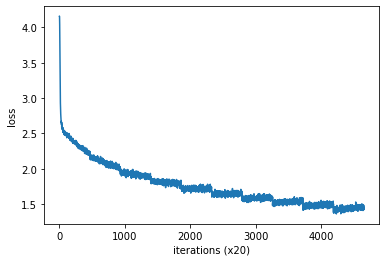

In [65]:
# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

---

### CBOWモデルの評価

In [67]:
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.72900390625
 i: 0.70263671875
 your: 0.6201171875
 someone: 0.59033203125
 they: 0.57373046875

[query] year
 month: 0.873046875
 spring: 0.771484375
 week: 0.77099609375
 summer: 0.75732421875
 decade: 0.7021484375

[query] car
 window: 0.666015625
 truck: 0.63232421875
 auto: 0.61279296875
 cars: 0.611328125
 luxury: 0.58447265625

[query] toyota
 honda: 0.68603515625
 nec: 0.6474609375
 mazda: 0.63623046875
 nissan: 0.634765625
 weyerhaeuser: 0.623046875
